# Understanding Variational Autoencoder

The notebook documents my explorations in undertsanding how to train a directed probabilistic models and deep latent variable models using variational inference. Here, I explore different aspects of the paper *Autoencoding Variational Bayes*, and the book *An Introduction to Variational AutoEncoders* both written/coauthored by ***Diederik P. Kingma1 and Max Welling***. 
<br><br>
My readings and notes on both materials are documented in this[note](here) and my [blog](blog_link). These spaces are where I write for personal recollection, and I hope any one who comes across them finds them useful for quick intuitive understanding of this topic.

This notebook is in two sections
1) An exploration and understanding of the concepts and objective of the Variational AutoEncoder.
   - Mathematically and visually look into understanding the model parameters, prior and posterior distributions
   - Explore ELBO - Evidence Lower Bound
   - Reparametrization Trick
   - Optimization methods for updating parameters of the model.  <br><br>
  
2) Understand how to train a Variational Autoencoder using two examples
   - Bernoulli VAE with a gaussian prior.
   - Gaussian VAE with a gaussian prior.

# 00 - Set up

In [1]:
# import dependencies
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np

2024-07-08 15:33:02.396535: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-08 15:33:02.396679: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-08 15:33:02.396909: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-08 15:33:02.456621: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Helper Functions

In [2]:
def plot_samples(arr, num_rows = 2, num_cols = 6, title = "Sample Dataset", cmap = None, shuffle = True):
    fig, ax = plt.subplots(num_rows, num_cols, figsize = (num_cols * 2, num_rows * 2))
    if shuffle:
        seed = np.random.randint(200)
        np.random.shuffle(arr)
    selection = np.random.choice(np.arange(0, len(arr)), num_rows * num_cols, replace = False)
    ax = ax.flatten()
    for i in range(len(ax)):
        ax[i].imshow(arr[i], cmap = cmap)
        ax[i].axis('off')
    fig.suptitle(title)
    plt.tight_layout()

# 02 - Bernoulli VAE

## 2A - Bernoulli VAE

### Load and Preprocess Data

In [3]:
# use this for bernoulli data
mnist_train, mnist_val = tf.keras.datasets.mnist.load_data()

In [4]:
print('Train set:', mnist_train[0].shape[0])
print('Validation set:', mnist_val[0].shape[0])

Train set: 60000
Validation set: 10000


In [5]:
def preprocess_mnist(data):
    data = np.expand_dims(data, axis = -1)
    data = data / 255
    data = np.where(data < 0.2, 0, 1)
    return data

In [6]:
# rescale images from 0 to 1
mnist_train_images = preprocess_mnist(mnist_train[0])
mnist_val_images = preprocess_mnist(mnist_val[0])

In [7]:
mnist_train_images.shape

(60000, 28, 28, 1)

In [8]:
mnist_train_y = [
    mnist_train_images,  [
        np.zeros(mnist_train_images.shape[0]),  
        np.zeros(mnist_train_images.shape[0]), 
        np.zeros(mnist_train_images.shape[0])
    ]
]
mnist_val_y = [
    mnist_val_images, [
        np.zeros(mnist_val_images.shape[0]),  
        np.zeros(mnist_val_images.shape[0]), 
        np.zeros(mnist_val_images.shape[0])
    ]
]

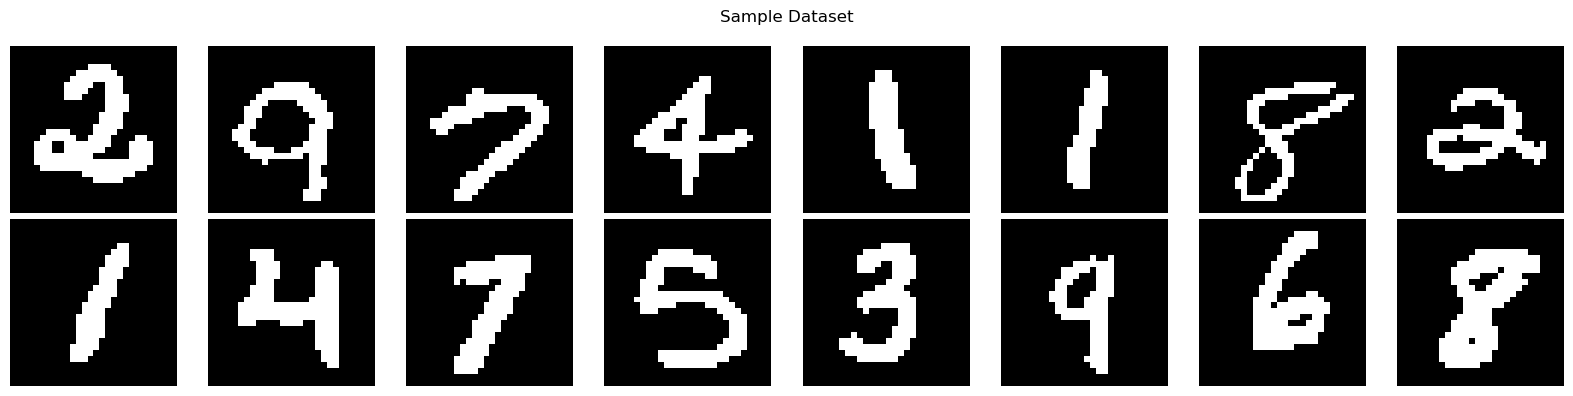

In [9]:
plot_samples(mnist_train_images, num_cols = 8, num_rows = 2, cmap = 'Greys_r')

### Define VAE architecture

In [10]:
INPUT_SHAPE = mnist_train_images.shape[1:]
LATENT_DIM = 4
INPUT_SHAPE

(28, 28, 1)

In [11]:
def build_encoder(input_shape, latent_dim = 2, downsample = 2, filter_size = 32, kernel_size = 3, strides = 2, padding = 'same'): 
    input = tf.keras.layers.Input(shape = input_shape, name = 'encoder_input')
    x = input
    for i in range(downsample):
        x = tf.keras.layers.Conv2D(filter_size * 2**i, kernel_size = kernel_size, padding = padding, strides = strides, activation = None, use_bias = False)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(latent_dim * 2)(x)
    mu, logvar = tf.keras.layers.Lambda(lambda x: tf.split(x, 2, axis = -1))(x)
    # mu = tf.keras.layers.Dense(latent_dim, name = 'z_mean', activation = 'relu')(x)
    # logvar = tf.keras.layers.Dense(latent_dim, name = 'z_logvar')(x)
    model = tf.keras.models.Model(inputs = input, outputs = [mu, logvar], name = 'encoder')
    return model
        

In [12]:
def build_decoder(latent_dim = 3, upsample = 2, base_size = 7, filter_size = 32, padding = 'same', strides = 1, kernel_size = 3, activation = 'relu'):
    input = tf.keras.layers.Input(shape = (latent_dim,))
    x = input
    x = tf.keras.layers.Dense(base_size * base_size * filter_size, activation = 'relu')(x)
    x = tf.keras.layers.Reshape([base_size, base_size, filter_size])(x)
    for i in range(upsample, 0, -1):
        x = tf.keras.layers.Conv2DTranspose(filter_size * i, kernel_size = kernel_size, padding = padding, strides = 2, activation = 'linear', use_bias = False)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2DTranspose(1, kernel_size = kernel_size, padding = padding, strides = strides, activation = None)(x)
    model = tf.keras.models.Model(inputs = input, outputs = x,  name = 'decoder')
    return model

In [13]:
encoder = build_encoder(INPUT_SHAPE, LATENT_DIM)
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 32)        288       
                                                                 
 batch_normalization (Batch  (None, 14, 14, 32)        128       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18432     
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 64)          256       
 chNormalization)                                          

2024-07-08 15:33:09.399163: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-08 15:33:09.732975: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-08 15:33:09.733046: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-08 15:33:09.737227: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-08 15:33:09.737359: I tensorflow/compile

In [14]:
decoder = build_decoder(LATENT_DIM)
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_1 (Dense)             (None, 1568)              7840      
                                                                 
 reshape (Reshape)           (None, 7, 7, 32)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        18432     
 anspose)                                                        
                                                                 
 batch_normalization_2 (Bat  (None, 14, 14, 64)        256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 14, 14, 64)        0   

In [15]:
class VAEncoder(tf.keras.models.Model):
    def __init__(self, input_shape, latent_dim, encoder_params = {}, decoder_params = {}, apply_sigmoid = False, **kwargs):
        super().__init__(**kwargs)
        self.input_dim = input_shape
        self.latent_dim = latent_dim
        assert 'input_shape' not in encoder_params, 'input_shape must not be part of encoder params'
        assert 'latent_dim' not in encoder_params, 'latent_dim must not be part of encoder params'
        self.encoder = build_encoder(self.input_dim, self.latent_dim, **encoder_params)
        self.decoder = build_decoder(self.latent_dim, **decoder_params)
        self.apply_sigmoid = apply_sigmoid

    def encode(self, inputs):
        mu, logvar = self.encoder(inputs)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        eps = tf.random.normal(shape=tf.shape(mu))
        return mu + tf.exp(logvar * 0.5) * eps

    def decode(self, inputs, apply_sigmoid = False):
        out = self.decoder(inputs)
        if apply_sigmoid or self.apply_sigmoid:
            out = tf.sigmoid(out)
        return out

    def call(self, inputs):
        mu, logvar = self.encode(inputs)
        z = self.reparameterize(mu, logvar)
        x = self.decode(z)
        return x, [mu, logvar, z]

    @tf.function
    def sample(self,  eps = None, num_samples = 20):
        if eps is None:
            eps = tf.random.normal(shape=(num_samples, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)


In [16]:
def kl_divergence():
    def inner_func(y_true, y_pred):
        print(y_pred[0], y_pred[1], y_pred[2])
        return - 0.5 * tf.reduce_sum((1 + y_pred[1] - tf.square(y_pred[0]) - tf.exp(y_pred[1])))
    return inner_func

In [17]:
vae_model = VAEncoder(INPUT_SHAPE, LATENT_DIM, apply_sigmoid = True)
vae_model.build([None] + list(INPUT_SHAPE))
vae_model.compile(
    loss = {
        'bce': tf.keras.losses.BinaryCrossentropy(from_logits = False, reduction = 'sum'),
        'kld': kl_divergence()
    },
    loss_weights = [1, 3],
    metrics = [['mae'], [None, None, None]],
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3)
)

In [18]:
history = vae_model.fit(mnist_train_images, mnist_train_y, validation_data = (mnist_val_images, mnist_val_y), epochs = 50, batch_size = 32)

Epoch 1/50
Tensor("inner_func/strided_slice:0", shape=(4,), dtype=float32) Tensor("inner_func/strided_slice_1:0", shape=(4,), dtype=float32) Tensor("inner_func/strided_slice_2:0", shape=(4,), dtype=float32)
Tensor("inner_func/strided_slice:0", shape=(4,), dtype=float32) Tensor("inner_func/strided_slice_1:0", shape=(4,), dtype=float32) Tensor("inner_func/strided_slice_2:0", shape=(4,), dtype=float32)


2024-07-08 15:33:13.936216: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-07-08 15:33:15.411502: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f8144d1c280 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-08 15:33:15.411572: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Laptop GPU, Compute Capability 8.6
2024-07-08 15:33:15.418331: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-08 15:33:15.497822: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1875/1875 [==============================] - 24s 10ms/step - loss: 4526.3848 - output_1_loss: 4480.7217 - output_2_1_loss: 15.2206 - output_1_mae: 0.1155 - val_loss: 4038.6492 - val_output_1_loss: 4001.9023 - val_output_2_1_loss: 12.2490 - val_output_1_mae: 0.1010
Epoch 2/50
1875/1875 [==============================] - 19s 10ms/step - loss: 3983.3735 - output_1_loss: 3951.4246 - output_2_1_loss: 10.6488 - output_1_mae: 0.1004 - val_loss: 3901.8369 - val_output_1_loss: 3870.5557 - val_output_2_1_loss: 10.4276 - val_output_1_mae: 0.0974
Epoch 3/50
1875/1875 [==============================] - 19s 10ms/step - loss: 3886.0010 - output_1_loss: 3858.8850 - output_2_1_loss: 9.0398 - output_1_mae: 0.0977 - val_loss: 3825.6836 - val_output_1_loss: 3800.4968 - val_output_2_1_loss: 8.3947 - val_output_1_mae: 0.0963
Epoch 4/50
1875/1875 [==============================] - 19s 10ms/step - loss: 3826.7393 - output_1_loss: 3803.2290 - output_2_1_loss: 7.8381 - output_1_mae: 0.0962 - val_loss: 3810.7915

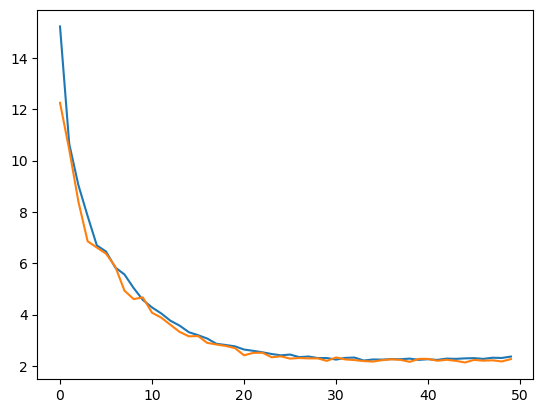

In [19]:
plt.plot(history.history['output_2_1_loss'])
plt.plot(history.history['val_output_2_1_loss'])

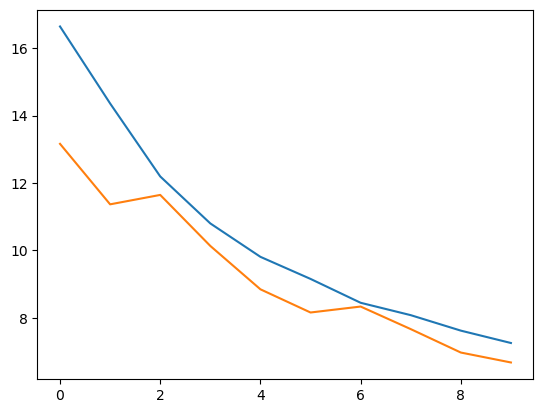

In [381]:
plt.plot(history.history['output_2_1_loss'])
plt.plot(history.history['val_output_2_1_loss'])

(20, 28, 28, 1)
(20, 4)


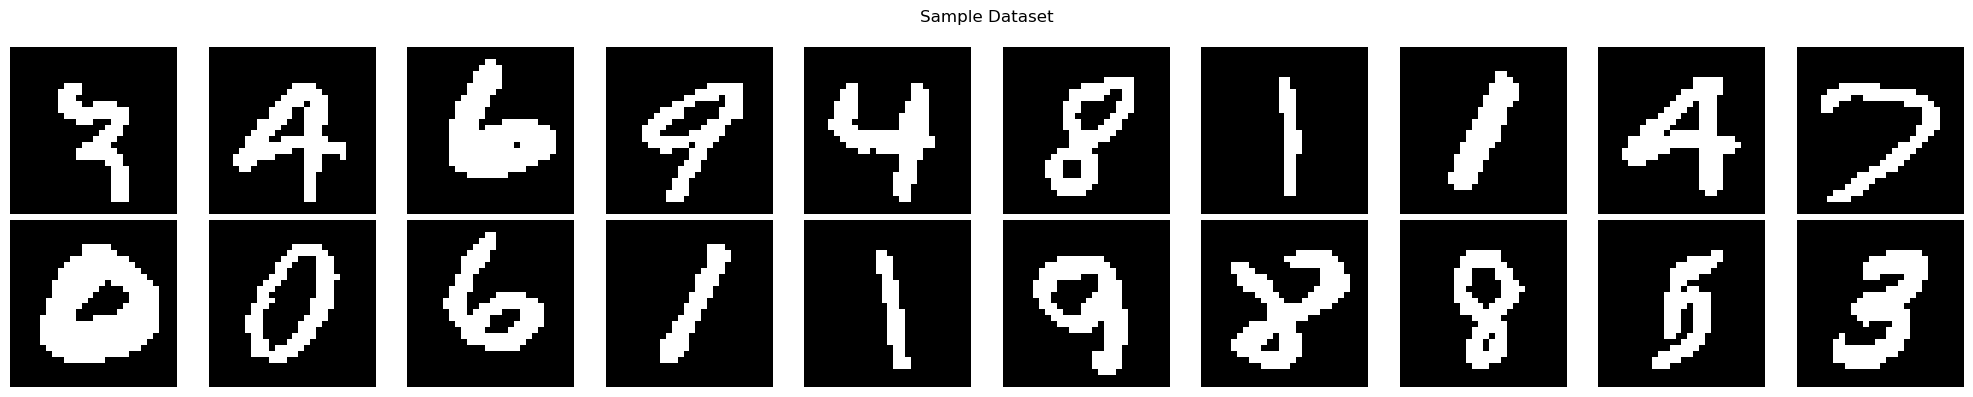

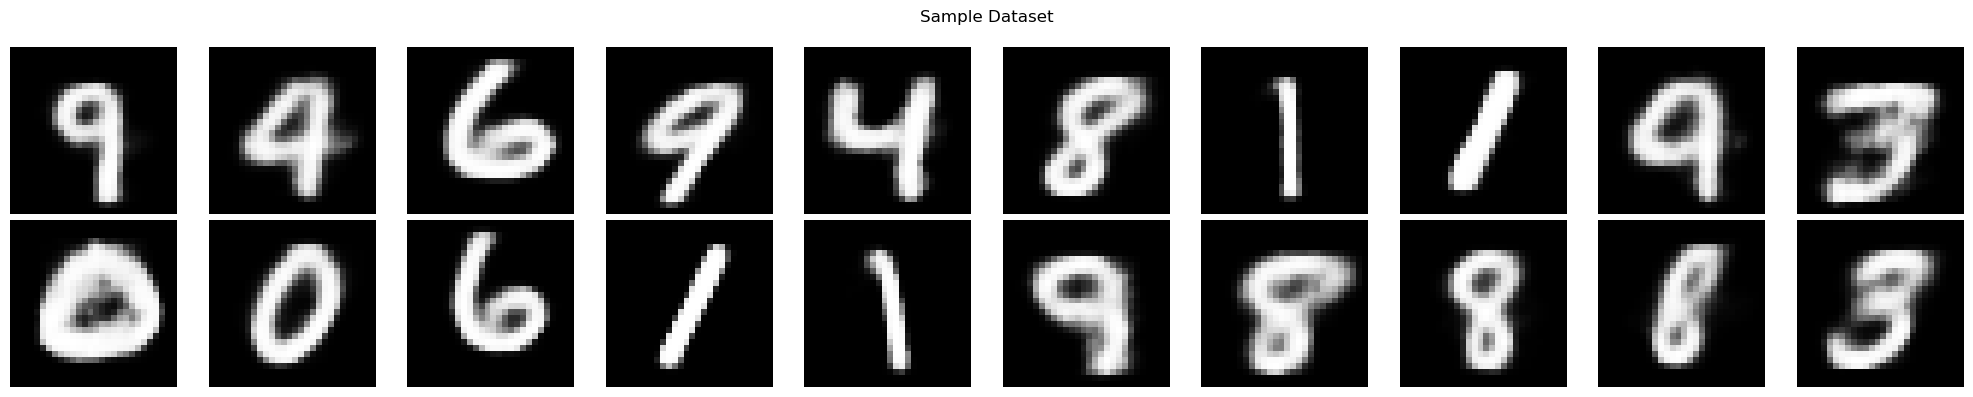

In [61]:
def generate_and_plot_samples(model):
    np.random.shuffle(mnist_val_images)
    arr = mnist_val_images[:20]
    print(arr.shape)
    mu, logvar = model.encode(arr)
    z = model.reparameterize(mu, logvar)
    print(z.shape)
    samples = model.sample(eps = z).numpy()
    plot_samples(arr, num_cols = 10, num_rows = 2, cmap = 'Greys_r', shuffle = False)
    plot_samples(samples, num_cols = 10, num_rows = 2, cmap = 'Greys_r', shuffle = False)
generate_and_plot_samples(vae_model)

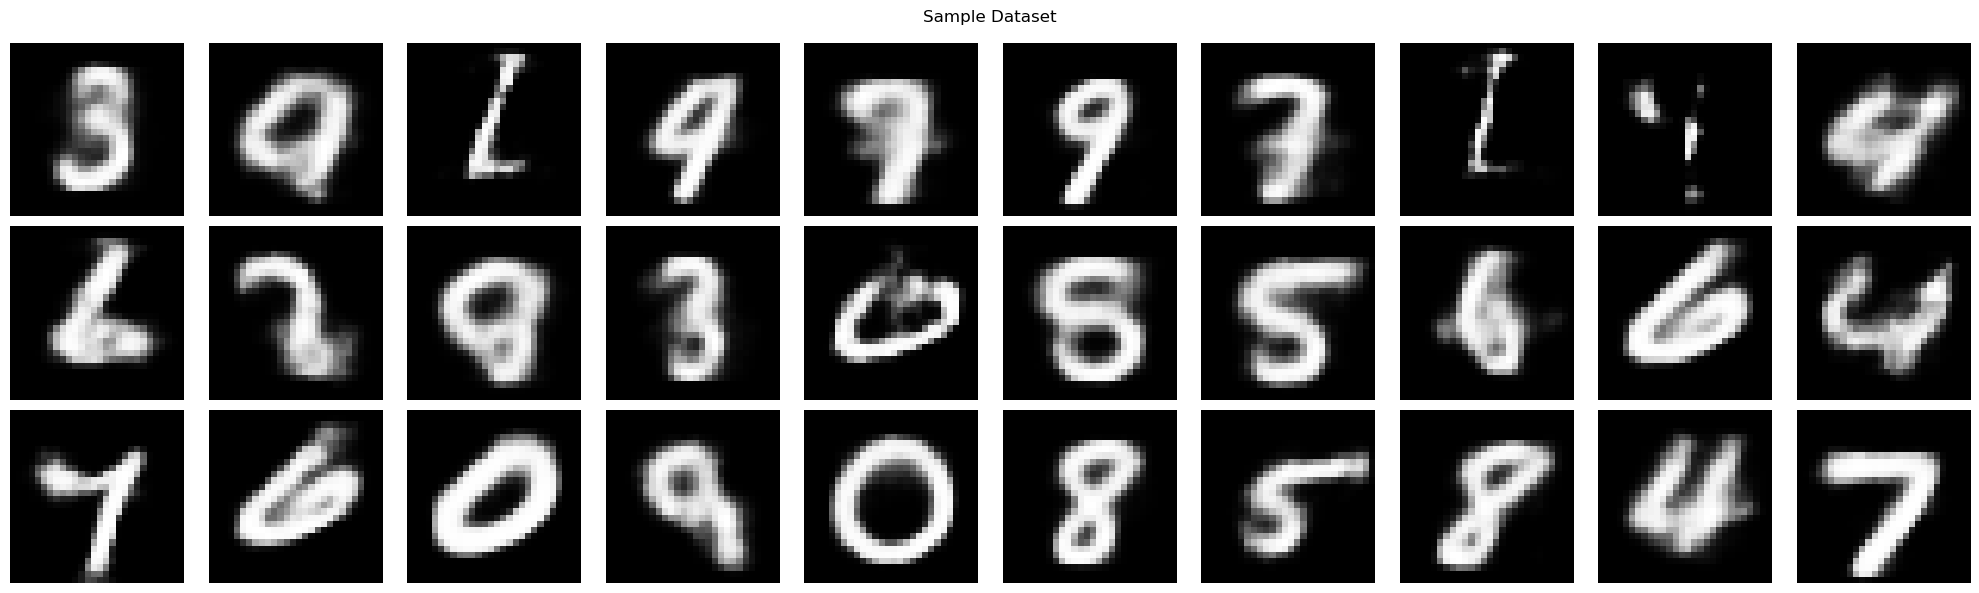

In [65]:
samples = vae_model.sample(num_samples = 30).numpy()
plot_samples(samples, num_cols = 10, num_rows = 3, cmap = 'Greys_r')

In [386]:
# def kl_divergence():
#     def inner_func(z, mu, logvar):
#     # I derived this manually. Would be good to show how it was worked out in the write up
#         kld = - 0.5 * (tf.square(z) - tf.square(z - mu) * tf.exp(-logvar) - logvar)
#         return keras.backend.abs(kld)
#     return inner_func

# kl_divergence()(2.0, 0, 2.0)

In [337]:
# def kl_divergence(b = 1e-8):
#     @tf.function
#     def inner_func(y_true, y_pred):
#         out = -tf.reduce_mean(log_norm(y_pred[2], y_true[0], y_true[1]) - log_norm(y_pred[2], y_pred[0], y_pred[1]))
#         # out = tf.reduce_mean(log_norm(y_pred[2], y_pred[0], y_pred[1]))
#         return out
#         # return tf.maximum(b, out)
#     return inner_func
# kl_divergence()([0.0, tf.math.log(tf.square(1.0))], [0.0, tf.math.log(tf.square(2.)), 0.7])

<tf.Tensor: shape=(), dtype=float32, numpy=0.50939715>

In [307]:
# @tf.function
def log_norm(z, mu, logvar):
    return -0.5 * (-keras.backend.square(z - mu) * keras.backend.exp(-logvar) - logvar)
    
    # return -0.5 * (-tf.square(z - mu) * tf.exp(-logvar) - logvar)
print(log_norm(2.,0.1, 0.))

tf.Tensor(1.805, shape=(), dtype=float32)


In [41]:
from sklearn.manifold import TSNE

In [54]:
def plot_latent_images(model, n, digit_size=28):
    """Plots n x n digit images decoded from the latent space."""

    norm = stats.norm(0, 1)
    grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
    grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
    grid_z = norm.ppf(np.linspace(0.05, 0.95, n))
    grid_v = norm.ppf(np.linspace(0.05, 0.95, n))
    image_width = digit_size*n
    image_height = image_width
    image = np.zeros((image_height, image_width))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            for k, zi in enumerate(grid_z):
                for w, vi in enumerate(grid_v):
                    z = np.array([[xi, yi, zi, vi]])
                    x_decoded = model.sample(z)
                    digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
                    image[i * digit_size: (i + 1) * digit_size,
                        j * digit_size: (j + 1) * digit_size] = digit.numpy()

    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='Greys_r')
    plt.axis('Off')
    plt.show()

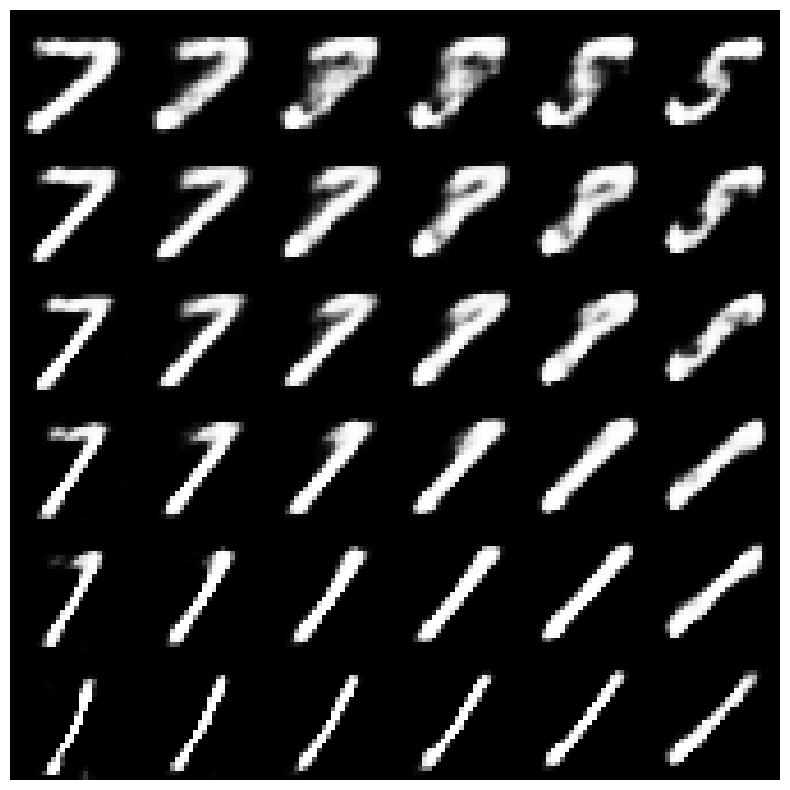

In [59]:
plot_latent_images(vae_model, 6)

In [32]:
from scipy import stats
a = np.log(stats.norm.pdf(0.7, 0, 1))
b = np.log(stats.norm.pdf(0.7, 0, 2))
print(a, b, a - b)

-1.1639385332046728 -1.6733357137646179 0.5093971805599451


## 02 - Gaussian VAE

In [34]:
# data 2, use the cartoons dataset for this instead. 
# to demonstrate gaussian output
# in another notebook to do gaussian covariate prior 
# to show that there is a spatial relationship to pixels really and pixels that are one level apart can be related